#### iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : iris.csv에서 2개 Feature 사용
- 구현프레임워크 : Pytorch

- [1] 모듈 로딩 및 데이터 준비

In [91]:
# 모듈 로딩
import torch                    # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn           # 인공신경망 관련 모듈
import torch.nn.functional as F    # 손실, 거리 등 함수 관련 모듈
import torch.optim as optimizer # 최적화 기법 관련 모듈
import pandas as pd             # 데이터 파일 분석 관련 모듈
from sklearn.model_selection import train_test_split        

In [92]:
torch.manual_seed(1)

In [93]:
# 데이터 로딩 : CSV => DataFrame
DATA_FILE='../data/iris.csv'

irisDF=pd.read_csv(DATA_FILE, usecols=[0,1,2,3])
irisDF.head()

,sepal.length,sepal.width,petal.length,petal.width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


[2] 모델 준비
- 학습방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 >> 선형모델 ==> nn.Linear

In [94]:
# in_features : sepal.length, sepal.width, petal.length 3개
# out_features : petal.width 1개
model=nn.Linear(3,10)

nnmodel=nn.Sequential(nn.Linear(3,10), nn.ReLU(), nn.Linear(10,50), nn.ReLU(), nn.Linear(50,1))

In [95]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[weight] Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119]], requires_grad=True)

[bias] Parameter containing:
tensor([0.2710], requires_grad=True)



[3] 최적화 인스턴스 준비

In [96]:
### 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim=optimizer.Adam(model.parameters(),lr=0.1)

[4] 학습 ==> 개발자가 구현

- [4-1] 데이터셋 Tensor화 진행 : 데이터 준비 시 진행하거나 또는 학습 전 진행

In [97]:
featureTS=torch.from_numpy(irisDF[irisDF.columns[:-1]].values).float()
featureTS.shape

torch.Size([150, 3])

In [98]:
targetTS=torch.from_numpy(irisDF[['petal.width']].values).float()
targetTS.shape

torch.Size([150, 1])

In [99]:
# Train & Test
X_train, X_test, y_train, y_test=train_test_split(featureTS,targetTS,test_size=0.2)

# Train & Valid
X_train, X_val, y_train, y_val= train_test_split(X_train, y_train, test_size=0.2)

print(f'[FEATURE] TRAIN {X_train.shape} TEST {X_test.shape}, VAL {X_val.shape}')
print(f'[TARGET] TRAIN {y_train.shape} TEST {y_test.shape}, VAL {y_val.shape}')

[FEATURE] TRAIN torch.Size([96, 3]) TEST torch.Size([30, 3]), VAL torch.Size([24, 3])
[TARGET] TRAIN torch.Size([96, 1]) TEST torch.Size([30, 1]), VAL torch.Size([24, 1])


- [4-2] 학습 진행 
    * 학습회수 결정 ==> 에포크 설정
    * 학습결과 저장 ==> 손실저장 변수


In [100]:
EPOCH=10
loss_history=[]

In [101]:
## 테스트/검증 함수
# ==> 가중치, 절편 업데이트 X, 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행
def testing(testTS, targetTS, kind='Val'):



    with torch.no_grad():       # 가중치 및 절편 업데이트 진행 X
        # (1) 학습진행 - forward
        pre_y=model(testTS)
        print(f'{pre_y.shape}')
        # (2) 오차계산 - 손실함수
        loss=F.mse_loss(pre_y, targetTS)
      

        # (4) 학습결과 출력 및 저장
        print(f'[{kind}] LOSS : {loss}')

    return loss

In [102]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS):

    loss_history=[[],[]]

    for epoch in range(EPOCH):
        # (1) 학습진행 - forward
        pre_y=model(featureTS)
        
        # (2) 오차계산 - 손실함수
        loss=F.mse_loss(pre_y, targetTS)
        loss_history[0].append(loss.item())

        # (3) 최적화 - 가중치, 절편 업데이트 backward
        adam_optim.zero_grad()
        loss.backward()
        adam_optim.step()

        # (4) 검증 - 모델이 제대로 만들어지는 검사용
        val_loss=testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())

        # (5) 학습결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}] LOSS : {loss}')

    return loss_history

In [103]:
# 모델 학습 진행
loss=training(X_train, y_train, X_val, y_val)

torch.Size([24, 1])
[Val] LOSS : 1.3649650812149048
[0/10] LOSS : 0.6309512257575989
torch.Size([24, 1])
[Val] LOSS : 0.6762412190437317
[1/10] LOSS : 1.2472431659698486
torch.Size([24, 1])
[Val] LOSS : 0.48194631934165955
[2/10] LOSS : 0.5585246682167053
torch.Size([24, 1])
[Val] LOSS : 0.7164894938468933
[3/10] LOSS : 0.3917931616306305
torch.Size([24, 1])
[Val] LOSS : 0.6010492444038391
[4/10] LOSS : 0.6618788838386536
torch.Size([24, 1])
[Val] LOSS : 0.33122479915618896
[5/10] LOSS : 0.5439190864562988
torch.Size([24, 1])
[Val] LOSS : 0.26784664392471313
[6/10] LOSS : 0.2642687261104584
torch.Size([24, 1])
[Val] LOSS : 0.3628993332386017
[7/10] LOSS : 0.21502476930618286
torch.Size([24, 1])
[Val] LOSS : 0.3525865375995636
[8/10] LOSS : 0.34000536799430847
torch.Size([24, 1])
[Val] LOSS : 0.21979957818984985
[9/10] LOSS : 0.34527647495269775


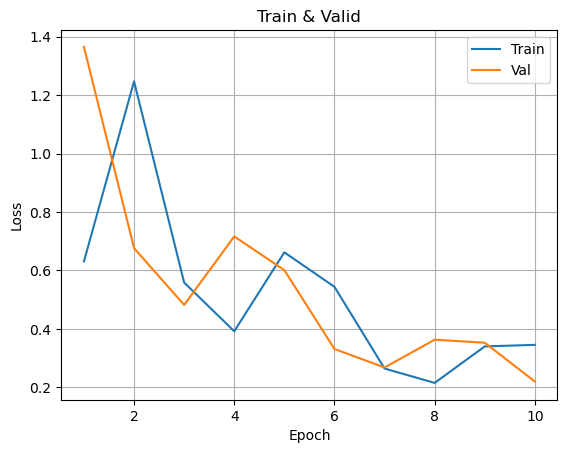

In [104]:
# 학습 후 loss 시각화
import matplotlib.pyplot as plt

plt.plot(range(1,11),loss[0], label='Train')
plt.plot(range(1,11),loss[1], label='Val')
plt.title('Train & Valid')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()